<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#wider-mask" data-toc-modified-id="wider-mask-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>wider mask</a></span></li></ul></div>

In [1]:
from app.settings import *

In [2]:
import pickle
import numpy as np
import cv2 as cv
from PIL import Image

In [3]:
import mrcnn.model as modellib
from mrcnn import visualize
import coco
import skimage
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
%matplotlib inline

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
model = modellib.MaskRCNN(mode='inference', model_dir=LIB_DIR, config=config)

W0623 12:04:24.940239 140734871016896 deprecation_wrapper.py:119] From /Users/toly/contests/photolab_slim/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 12:04:24.966984 140734871016896 deprecation_wrapper.py:119] From /Users/toly/contests/photolab_slim/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 12:04:24.972702 140734871016896 deprecation_wrapper.py:119] From /Users/toly/contests/photolab_slim/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0623 12:04:25.016622 140734871016896 deprecation_wrapper.py:119] From /Users/toly/contests/photolab_slim/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused

In [7]:
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [79]:
IMAGE_PATH = os.path.join(DATA_DIR, 'picture_5.jpg')

In [80]:
image = skimage.io.imread(IMAGE_PATH)

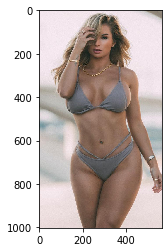

In [81]:
plt.imshow(image)

In [82]:
results = model.detect([image], verbose=1)

Processing 1 images
image                    shape: (1002, 564, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


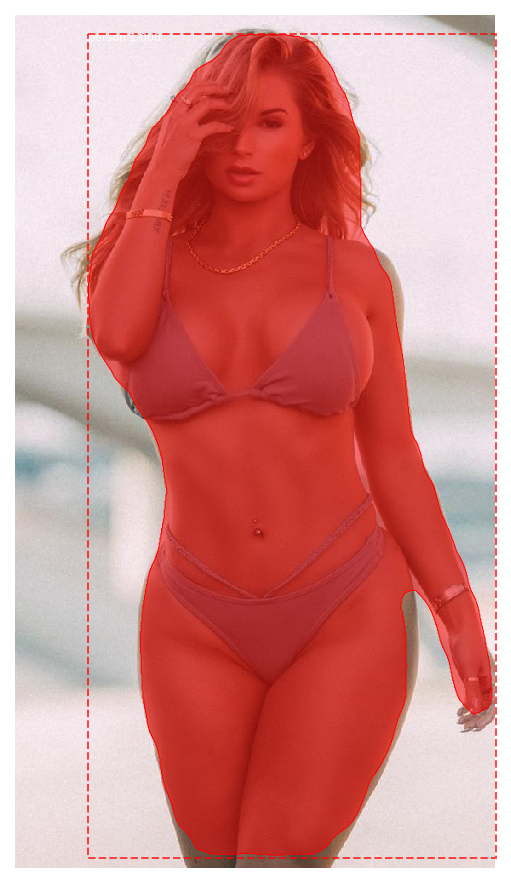

In [83]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
class_names = [0, 'person']
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [84]:
mask = r['masks'][:, :, 0]

In [85]:
_, x1, _, x2 = r['rois'][0]

In [86]:
dilate_wide = int((x2 - x1) * 0.05)

In [87]:
mask = cv.dilate((mask * 255).astype(np.uint8), np.ones((dilate_wide, dilate_wide), np.uint8))

In [88]:
image_4d = np.concatenate([image, mask[:, :, np.newaxis]], axis=2)

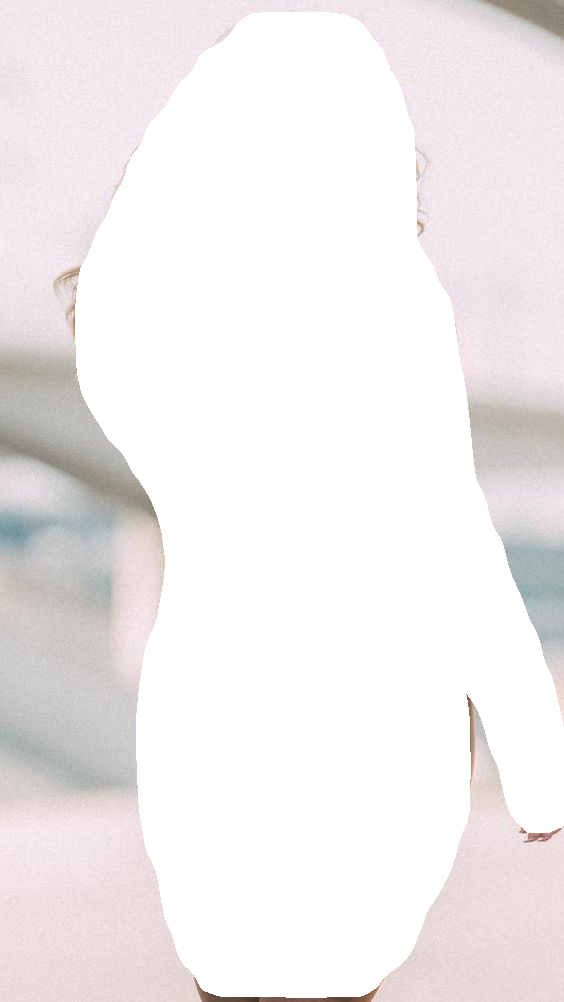

In [89]:
image_4d_zzz = np.concatenate([image, (255 - mask[:, :, np.newaxis])], axis=2)
image_4d_zzz = Image.fromarray(image_4d_zzz.astype(np.uint8), mode='RGBA')
image_4d_zzz

In [90]:
image_alpha = Image.fromarray(image_4d.astype(np.uint8), mode='RGBA')

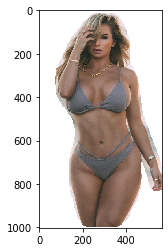

In [91]:
plt.imshow(image_alpha)

In [92]:
ratio = 0.85

In [93]:
resized_cut = image_alpha.resize((int(image_alpha.width * ratio), image_alpha.height), Image.ANTIALIAS)

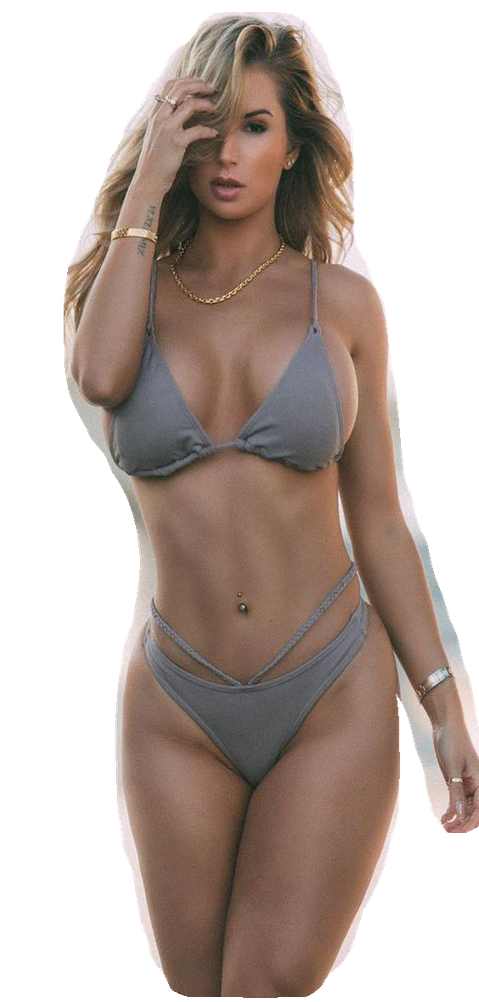

In [94]:
resized_cut

In [95]:
result_inpaint = cv.inpaint(image_4d[:, :, :3].astype(np.uint8), mask.astype(np.uint8) * 255, 5, cv.INPAINT_TELEA)

In [96]:
result_inpaint = Image.fromarray(result_inpaint)

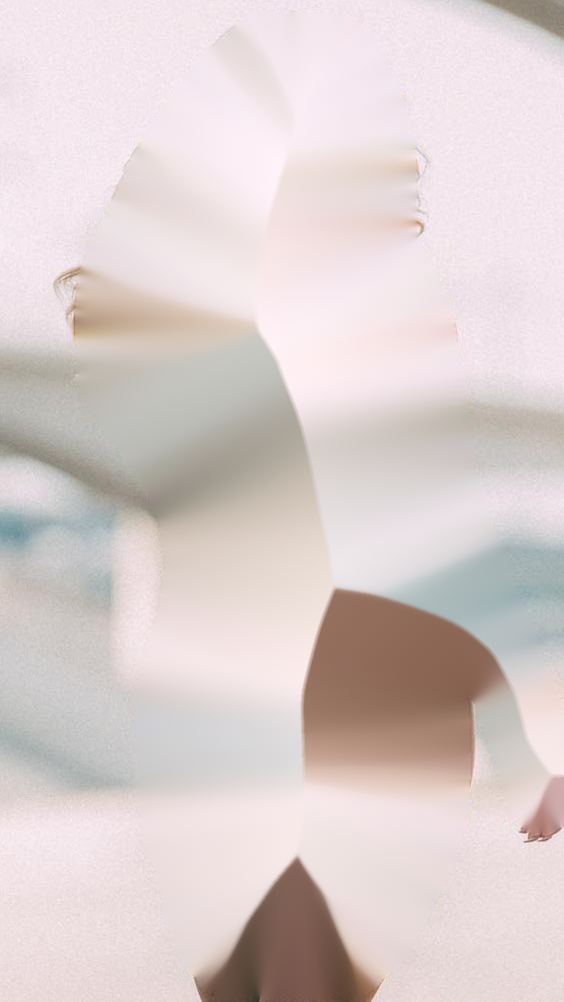

In [97]:
result_inpaint

In [98]:
_, x1, _, x2 = r['rois'][0]

In [99]:
new_x = int((x1 + x2) / 2 * (1 - ratio))

In [100]:
result_inpaint.paste(resized_cut, (new_x, 0), resized_cut)

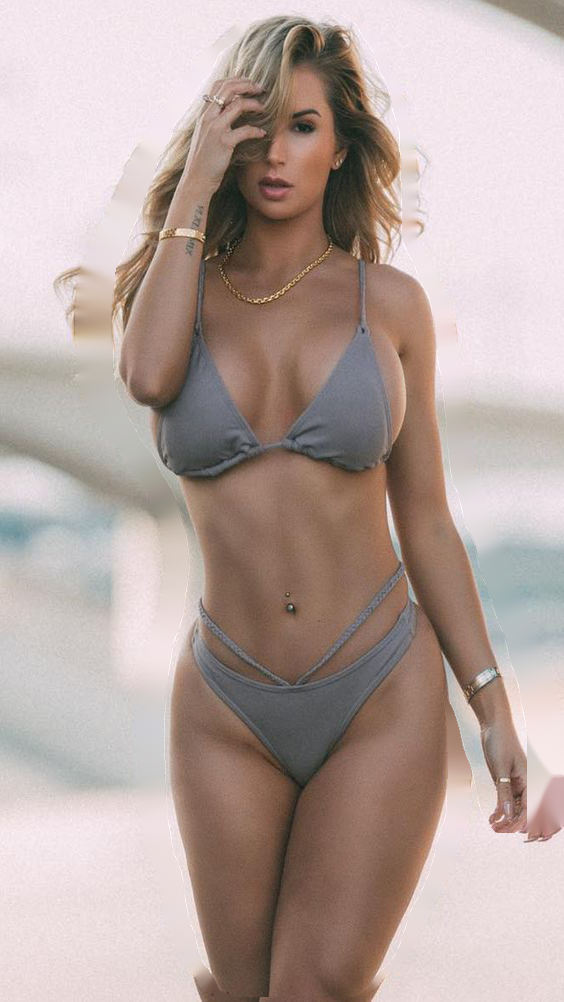

In [101]:
result_inpaint